Team name: Visages Villages

Team members: Gizem Dikdere, Özgün Deniz Gezerli

In [1]:
import pandas as pd
import numpy as np

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.classify.scikitlearn import SklearnClassifier


from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
data=pd.read_csv("MC2.csv",index_col=0,header=0)
data.head()

/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
1,0983797706,Igniting Your True Purpose and Passion: A Busi...,5,0,0,N,This is an inspirational and insightful book t...,This is an inspirational and insightful book t...
2,1423151283,The Duckling Gets a Cookie!? (Pigeon),5,0,0,N,Loved it!,My twins are 3 and they love the pigeon books!...
3,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,4,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."
4,0393057941,The Bread Bible,5,0,0,N,Great book for beginners,I disagree with those reviews that say this is...
5,1608322858,Do It Well. Make It Fun.: The Key to Success i...,3,2,2,N,Left me wanting more,"Reading this book, I hoped to find more about ..."


Data is loaded, index column and header are set to 0.

In [111]:
data=data.iloc[:200000,:]
data.describe()

,star_rating,helpful_votes,total_votes
count,200000.00000,200000.000000,200000.000000
mean,4.26367,3.589355,5.117995
std,1.18173,25.142021,29.256704
min,1.00000,0.000000,0.000000
25%,4.00000,0.000000,0.000000
50%,5.00000,1.000000,1.000000
75%,5.00000,3.000000,4.000000
max,5.00000,5275.000000,5666.000000


Instead of using the whole data, the first 200000 rows are used. This amount of data is enough for a multi-class classification task. Moreover, our computational power is insufficient to process 1 million rows.

In [112]:
data.tail()

,product_id,product_title,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
199996,1578635071,Saturn: A New Look at an Old Devil,1,7,8,N,1976 classic poorly reprinted.,The cover and paid forward by Robert Hand are ...
199997,0062038303,Sanctus: A Novel (The Sanctus Trilogy),3,2,4,N,You either buy into it or you don't,"Simon Toyne's \\""Sanctus\\"" will find an audie..."
199998,1601423829,"Life, In Spite of Me: Extraordinary Hope After...",3,2,2,N,Kritters Ramblings,An emotional story that from the very beginnin...
199999,B00342VFH8,The Money Workbook: A 30-day Program to Greate...,5,0,0,Y,very interesting book,I like the book it opens your mind with the ex...
200000,0764207520,"Unlikely Suitor, An",3,1,1,N,Review of An Unlikely Suitor,Head back to the year of 1895 and follow two g...


In [113]:
print(data[data["star_rating"]==0]) 
print(data[data["star_rating"]>5]) 
data.info()

Empty DataFrame
Columns: [product_id, product_title, star_rating, helpful_votes, total_votes, verified_purchase, review_headline, review_body]
Index: []
Empty DataFrame
Columns: [product_id, product_title, star_rating, helpful_votes, total_votes, verified_purchase, review_headline, review_body]
Index: []
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 1 to 200000
Data columns (total 8 columns):
product_id           200000 non-null object
product_title        200000 non-null object
star_rating          200000 non-null int64
helpful_votes        200000 non-null int64
total_votes          200000 non-null int64
verified_purchase    200000 non-null object
review_headline      199998 non-null object
review_body          200000 non-null object
dtypes: int64(3), object(5)
memory usage: 13.7+ MB


Above, star_rating column is checked if there are zeros or values more than 5. Since the resulting arrays are empty, it is certain that there are not any zeros or values more than 5. Just review_body and star_rating columns are used for this task and these columns do not have any null values. 

(array([ 12715.,      0.,   9269.,      0.,      0.,  16136.,      0.,
         36327.,      0., 125553.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

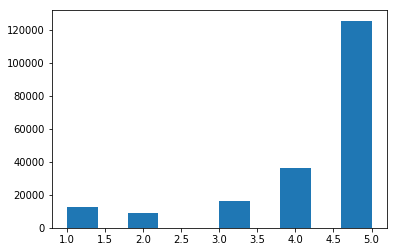

In [114]:
plt.hist(data["star_rating"])

In [115]:
print(data.star_rating.value_counts())

5    125553
4     36327
3     16136
1     12715
2      9269
Name: star_rating, dtype: int64


Star_rating is not distributed evenly but the neural network models capture this unevenness in training. There is no need to over or undersample.

BENCHMARK MODEL

To create a simple benchmark model, first tfidf vectorizer is used to vectorize the text data, then RandomForestClassifier is used as the model. 

In [66]:
databenchmark=data.iloc[:10000,:]

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(databenchmark.review_body)

The 'review_body' column is vectorized by using tfidfvectorizer. 

In [68]:
y=databenchmark["star_rating"]

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, y, test_size=0.2, random_state=42)

In [70]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()
classifier.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier is fitted to the train data.

In [81]:
preds = classifier.predict(X_test)
proba = classifier.predict_proba(X_test)

In [78]:
from sklearn.metrics import accuracy_score,log_loss
print('Accuracy score for benchmark: ', accuracy_score(y_test,preds))
print('Log_loss for benchmark: ', log_loss(y_test, proba))

Accuracy score for benchmark:  0.649
Log_loss for benchmark:  4.655074142723375


The accuracy score for benchmark is 0.65 and log loss is 4.655. 

PREPROCESSING FUNCTION

In [116]:
import string
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.translate(str.maketrans('','',string.punctuation)) #removes punc
    text=nltk.word_tokenize(text.lower()) #lowers and tokenizes
    text = [word for word in text if word not in stop_words] #removes stop words
    text = [lemmatizer.lemmatize(word, pos='n') for word in text]
    text = [lemmatizer.lemmatize(word, pos='v') for word in text]
    text = [lemmatizer.lemmatize(word, pos='a') for word in text]
    return text;

Clean_text function cleans the reviews. First, it removes punctuations. Then, it lowers and tokenizes the text. Afterwards, stop words are removed from text. Finally, nouns, verbs, and adjectives in the text are lemmatized.

WORD2VEC + LSTM

In [9]:
vocab=[]
for i in range(0,len(data)):
    a=clean_text(data.iloc[i,-1])
    vocab.append(a)

Vocab holds the cleaned version of review_body. 

In [31]:
from gensim.models import Word2Vec    


word2vec = Word2Vec(vocab, 
                 min_count=1,
                 window=100, 
                 iter =100, 
                 size=128, 
                 workers=2)

print(word2vec)

C:\Users\deniz\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Word2Vec(vocab=334971, size=128, alpha=0.025)


A Word2Vec model is trained using vocab. Min_count is selected as 1 to vectorize all words. Window size is determined as 100. Too small window size is not enough to capture the meaning of the review and too big window size is not optimal in terms of computational power. Iter is selected as 100. Size of embedding is 128. The trained word2vec model has 334971 word vectors.

In [32]:
embs_200k_100w="200k_100_window_embeddings.txt"
word2vec.wv.save_word2vec_format(embs_200k_100w, binary=False)

C:\Users\deniz\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Embeddings are saved to a text file in order to use later.

In [10]:
embeddings_index={}
with open("200k_100_window_embeddings.txt",encoding='utf8') as loaded_embs:
    for line in loaded_embs:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:])
        embeddings_index[word]=coefs

Embeddings are loaded from saved file.

In [11]:
from keras.preprocessing.text import Tokenizer
train_sentences=vocab
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_sentences)
seq=tokenizer_obj.texts_to_sequences(train_sentences)

Using TensorFlow backend.


Reviews are tokenized and converted to sequences.

In [19]:
from keras.preprocessing.sequence import pad_sequences
X_padded=pad_sequences(seq, 128) 

Sequences are padded with size of 128.

In [20]:
word_index=tokenizer_obj.word_index
len(word_index)

334971

334971 is the number of unique words which is the same with the vocab of word2vec model. This amount of words is enough for embedding.

In [21]:
num_words=len(word_index)+1
emb=128
embedding_matrix=np.zeros((num_words, emb))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector=embeddings_index[word]
    
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
print(embedding_matrix.shape)
print(num_words)

(334972, 128)
334972


Above, embedding matrix is created. If a word is not in word2vec embeddings, it gets zero value. The shape of the embedding matrix is (334972,128).

In [22]:
from keras.utils import to_categorical
y=data["star_rating"]
encoder=LabelEncoder()
y=encoder.fit_transform(y)
print(encoder.classes_)
y = to_categorical(y)


print(X_padded.shape) 
print(y.shape)

[1 2 3 4 5]
(200000, 128)
(200000, 5)


Labels are encoded,fitted, and transformed. Then, y is converted to categorical version.

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded,y, test_size = 0.2, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(160000, 128) (160000, 5)
(40000, 128) (40000, 5)


Padded and y split into train and test sets. Train set has 160000 entries. Test set has 40000 entries.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Flatten,SpatialDropout1D,LSTM
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras. initializers import Constant
input_dim=len(embedding_matrix)
model = Sequential()
model.add(Embedding(input_dim=input_dim,output_dim= emb,embeddings_initializer=Constant(embedding_matrix), input_length=128,trainable=True))
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001)])

W0630 15:44:30.396914  5588 deprecation.py:323] From C:\Users\deniz\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 128000 samples, validate on 32000 samples
Epoch 1/3
128000/128000 [==============================] - 1743s 14ms/step - loss: 0.9071 - acc: 0.6553 - val_loss: 0.8229 - val_acc: 0.6806
Epoch 2/3
128000/128000 [==============================] - 1652s 13ms/step - loss: 0.7877 - acc: 0.6934 - val_loss: 0.8043 - val_acc: 0.6863
Epoch 3/3
128000/128000 [==============================] - 1627s 13ms/step - loss: 0.7461 - acc: 0.7090 - val_loss: 0.8003 - val_acc: 0.6873


Sequential model is created and embedding layer is added. Embedding layer has the lenght of embedding matrix as input dimension, embedding size as output dimension, embedding matrix as embeddings initializer, and 128 as input length which is pad length. Trainable is set as True to train the weights during fitting.

Then, an LSTM layer is added to the model with 100 units and 0.2 as recurrent dropout rate. Recurrent dropout is added to the model to prevent overfitting. After LSTM layer, a Dense layer is added. Dense layer is necessary to predict classes. Since there are 5 classes, dense layer has 5 units. Activation function is softmax because this is a multi-class classification task.

For compiling the model, categorical crossentropy is used for loss because this is a multi-class classification model. Adam is selected as optimizer. Accuracy is set as metrics.

The model is trained for 3 epochs with 128 batch size. These parameters are set by hand to prevent overfitting.

Train loss is 0.7461. Train accuracy is 0.7090. Validation loss is 0.8003. Validation accuracy is 0.6873. There is no overfitting.

In [26]:
evaluation = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(evaluation[0],evaluation[1]))

40000/40000 [==============================] - 42s 1ms/step
Test set
  Loss: 0.802
  Accuracy: 0.686


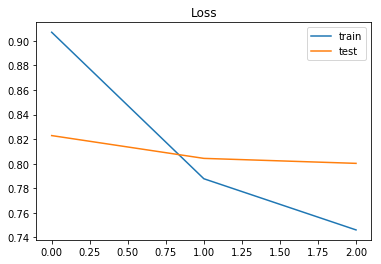

In [27]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Above, the graph of train and test loss in every epoch is plotted. There is no overfitting.

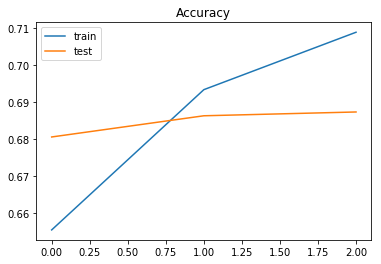

In [28]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

Above, the graph of train and test accuracy in every epoch is plotted. There is no overfitting.

GLOVE + LSTM

In [117]:
train_sentences=data['review_body'].apply(clean_text)

In [118]:
from keras.preprocessing.text import Tokenizer

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(train_sentences)
seq=tokenizer_obj.texts_to_sequences(train_sentences)
seq[1]

[1827,
 300,
 10,
 9228,
 1,
 4,
 52,
 195,
 9228,
 618,
 3277,
 224,
 534,
 578,
 21,
 17,
 5258,
 26,
 52,
 22,
 175,
 2,
 12,
 210,
 28,
 270]

Reviews are tokenized and converted to sequences.

In [119]:
from keras.preprocessing.sequence import pad_sequences
X_padded=pad_sequences(seq, 150)

Sequences are padded with size of 150.

In [120]:
from keras.utils import to_categorical
y=data["star_rating"]
encoder=LabelEncoder()
y=encoder.fit_transform(y)
print(encoder.classes_)
y = to_categorical(y)


print(X_padded.shape)
print(y.shape)

[1 2 3 4 5]
(200000, 150)
(200000, 5)


In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.25, random_state=111)

In [14]:
embeddings_index = {}
with open('/Users/gizemdikdere/Downloads/glove/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


After building the embedding using Word2vec, it is decided to use pre-trained embeddings. 'GloVe' is chosen. 

In [15]:
word_index=tokenizer_obj.word_index
len(word_index)

334971

334971 is the number of unique tokens.

In [16]:
num_words=len(word_index)+1
num_words

334972

In [ ]:
emb=100
gloved = np.zeros((len(word_index) + 1, emb))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        gloved[i] = embedding_vector

Here, the weights that will be in the embedding layer are created.  The shape of the weight matrix is (334972, 100). For the new words, it will use zero embeddings.  

In [18]:
from keras.layers.embeddings import Embedding
embedding_layer2 = Embedding(num_words,
                            emb,
                            weights=[gloved],
                            input_length=150,
                            trainable=False)

The embedding layer is created by using the weights from Glove and the input length of 150. It is chosen to set trainable equal to False because when weights are trainable, the overfitting behavior was observed quickly. 

In [19]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

optimizer=Adam(lr=0.001)

model3=Sequential()
model3.add(embedding_layer2)
model3.add(LSTM(100,recurrent_dropout=0.25))
model3.add(Dense(5, activation="softmax"))
model3.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model3.summary()

history3=model3.fit(X_train,y_train, batch_size=128, epochs=7, validation_split=0.2, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          33497200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 33,578,105
Trainable params: 80,905
Non-trainable params: 33,497,200
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 120000 samples, validate on 30000 samples
Epoch 1/7
120000/120000 [==============================] - 301s 3ms/step - loss: 0.9585 - acc: 0.6438 -

In the model, after the embedding layer, LSTM layer with 100 nodes is used. Recurrent dropout is used to prevent overfitting. In the Dense layer, there are 5 nodes because we have 5 classes to predict. The activation function is softmax. For the loss, categorical cross entropy is used since the task is multiclass classification. Adam optimizer with learning rate 0.001 is preferred. Batch size is 128 and the epoch number is 7. 

In [20]:
scores={}
score_gl = model3.evaluate(X_test, y_test, verbose=0)
scores["GRU_glove_wikipedia"] = score_gl
print('Test loss:', score_gl[0])
print('Test accuracy:', score_gl[1])

Test loss: 0.7934245466423034
Test accuracy: 0.68954


After fitting and compiling the model, the test loss is 0.79 and the test accuracy is around 0.69.

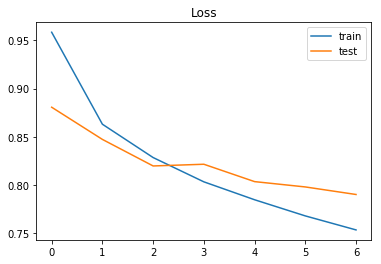

In [21]:
plt.title('Loss')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()

Here is the graph of train and test losses in every epoch. 

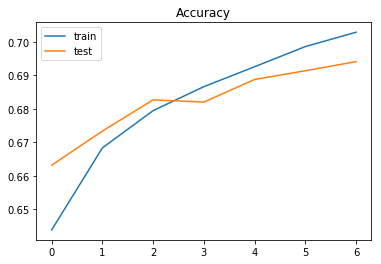

In [22]:
plt.title('Accuracy')
plt.plot(history3.history['acc'], label='train')
plt.plot(history3.history['val_acc'], label='test')
plt.legend()
plt.show()

Here is the graph of train and test accuracy in every epoch. There is no overfitting. 

In terms of parameter tuning, we didn't use GridSearch because we don't have that much computational power. Instead, we tried several models by hand and then decided to use the parameters we have in the model. 

In [125]:
from sklearn.metrics import confusion_matrix
X_test.shape
print ('\nConfusion matrix:\n', confusion_matrix(np.argmax(y_test,axis=1),model3.predict_classes(X_test)))


Confusion matrix:
 [[ 1914   353   218   164   548]
 [  711   462   443   237   500]
 [  358   443   996  1012  1195]
 [  218   154   762  2729  5318]
 [  540   125   560  3433 26607]]


The confusion matrix is created. The prediction of ratings are distributed unevenly. The model captured and considered the imbalance of the data and predicted accordingly.

FINAL PREDICTIONS FOR MC2TEST





The predictions are created with the model with Glove embedding. The loss for the Glove model is lower than the model with Word2vec and also is lower than our benchmark loss. 

In [137]:
test_data=pd.read_csv("MC2test.csv",index_col=0,header=0)
test_data.head()

,product_id,product_title,helpful_votes,total_votes,verified_purchase,review_headline,review_body
1,1445604752,Spitfire Ace of Aces: The Wartime Story of Joh...,2,2,N,Engaging Account of the Combat Career of an RA...,"Back in 1964, I was introduced to 'Johnnie' Jo..."
2,080244864X,Hush: Moving From Silence to Healing After Chi...,1,1,N,Best Book Ever (Next to the Bible,This book has helped me through a lot this pas...
3,0312536984,Eviction Notice: A Hood Rat Novel (Hood Rat No...,0,0,N,Wild and Crazy,A gripping read! K'wan is on fire with this n...
4,1609412427,Vegan Cooking for Carnivores: Over 125 Recipes...,87,90,Y,Cooking up a storm and loving it!,I love this book. I've had it about four days...
5,0876059515,The Complete Book of Foaling: An Illustrated G...,1,1,N,The best foaling book on the market,As both a long-time horse owner and fulltime w...


In [138]:
X_MC2_test=test_data.review_body.apply(clean_text)
test_seq=tokenizer_obj.texts_to_sequences(X_MC2_test)
test_padded=pad_sequences(test_seq, 150) 
predicted_classes=model3.predict_classes(test_padded)
print(predicted_classes)
predicted_classes=predicted_classes+1
print(predicted_classes)

[3 4 4 ... 4 0 3]
[4 5 5 ... 5 1 4]


In [139]:
test_data['star_rating']= predicted_classes

In [140]:
test_data=test_data[['product_id', 'star_rating']]
test_data.head()

,product_id,star_rating
1,1445604752,4
2,080244864X,5
3,0312536984,5
4,1609412427,5
5,0876059515,5


In [143]:
test_data['product_id']=test_data['product_id'].astype('str')
test_data.head()

,product_id,star_rating
1,1445604752,4
2,080244864X,5
3,0312536984,5
4,1609412427,5
5,0876059515,5


In [155]:
import csv
test_data.to_csv("MC2_[VisagesVillages].csv",index=False,quoting=csv.QUOTE_NONNUMERIC)

In conclusion, the predictions of star ratings are created by using Glove model. Then, they are written to the MC2test table. Finally, the predictions are saved to predictions.csv. 